In [45]:
import matplotlib.pyplot as plt 
import os 
import tqdm 
import pprint 
pp = pprint.PrettyPrinter(indent=4)
import numpy as np
import pandas as pd 
import cv2
import seaborn as sns

In [2]:
TRAIN_IMAGES = "/home/shirshak/Thesis_Data/Steel_Scrap_detection/train/images"
TRAIN_LABELS = "/home/shirshak/Thesis_Data/Steel_Scrap_detection/train/labels"
VAL_IMAGES = "/home/shirshak/Thesis_Data/Steel_Scrap_detection/valid/images"
VAL_LABELS = "/home/shirshak/Thesis_Data/Steel_Scrap_detection/valid/labels"
TEST_IMAGES = "/home/shirshak/Thesis_Data/Steel_Scrap_detection/test/images"
TEST_LABELS = "/home/shirshak/Thesis_Data/Steel_Scrap_detection/test/labels"


classes = ['Capacitor', 'Cylinder', 'Motor', 'Shock absorber', 'container']

Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}


print("Index to Label Mapping:", Idx2Label)
print("Label to Index Mapping:", Label2Index)

Index to Label Mapping: {0: 'Capacitor', 1: 'Cylinder', 2: 'Motor', 3: 'Shock absorber', 4: 'container'}
Label to Index Mapping: {'Capacitor': 0, 'Cylinder': 1, 'Motor': 2, 'Shock absorber': 3, 'container': 4}


/tmp/ipykernel_702320/2262522257.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


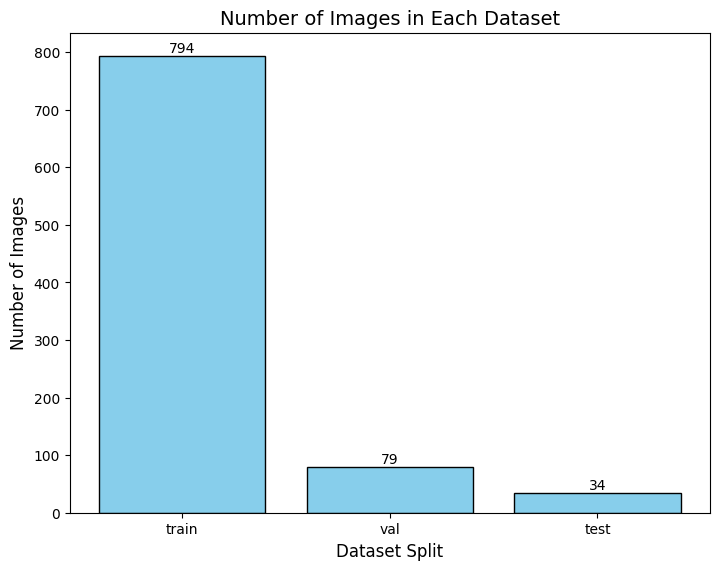

In [3]:
def plot_num_images(data, title):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    bars = ax.bar(data.keys(), data.values(), color='skyblue', edgecolor='black')
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Dataset Split", fontsize=12)
    ax.set_ylabel("Number of Images", fontsize=12)
    
    # Add counts above bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1, str(height),
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
def get_num_images(path):
    return len(os.listdir(path))

plot_num_images({ "train": get_num_images(TRAIN_IMAGES), "val": get_num_images(VAL_IMAGES), "test": get_num_images(TEST_IMAGES) }, "Number of Images in Each Dataset")

In [4]:
def count_objects_per_images(image_dir, label_dir, object_count, total_object_count):
    image_files = sorted(os.listdir(image_dir))
    for image_file in tqdm.tqdm(image_files):
        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        total_object_count.append(len(lines))
        for line in lines:
            object_count[Idx2Label[int(line.split()[0])]] = object_count.get(Idx2Label[int(line.split()[0])], 0) + 1
        f.close()

In [5]:
train_object_count = {}
val_object_count = {}
test_object_count = {}

total_object_per_train_count = []
total_object_per_val_count = []
total_object_per_test_count = []

count_objects_per_images(TRAIN_IMAGES, TRAIN_LABELS, train_object_count, total_object_per_train_count)
count_objects_per_images(VAL_IMAGES, VAL_LABELS, val_object_count, total_object_per_val_count)
count_objects_per_images(TEST_IMAGES, TEST_LABELS, test_object_count, total_object_per_test_count)

100%|██████████| 34/34 [00:00<00:00, 13607.47it/s]


In [6]:
pp.pprint(train_object_count)
print()
pp.pprint(val_object_count)
print()
pp.pprint(test_object_count)

{   'Capacitor': 273,
    'Cylinder': 2299,
    'Motor': 251,
    'Shock absorber': 1010,
    'container': 782}

{   'Capacitor': 29,
    'Cylinder': 267,
    'Motor': 7,
    'Shock absorber': 68,
    'container': 136}

{'Cylinder': 96, 'Shock absorber': 96, 'container': 50}


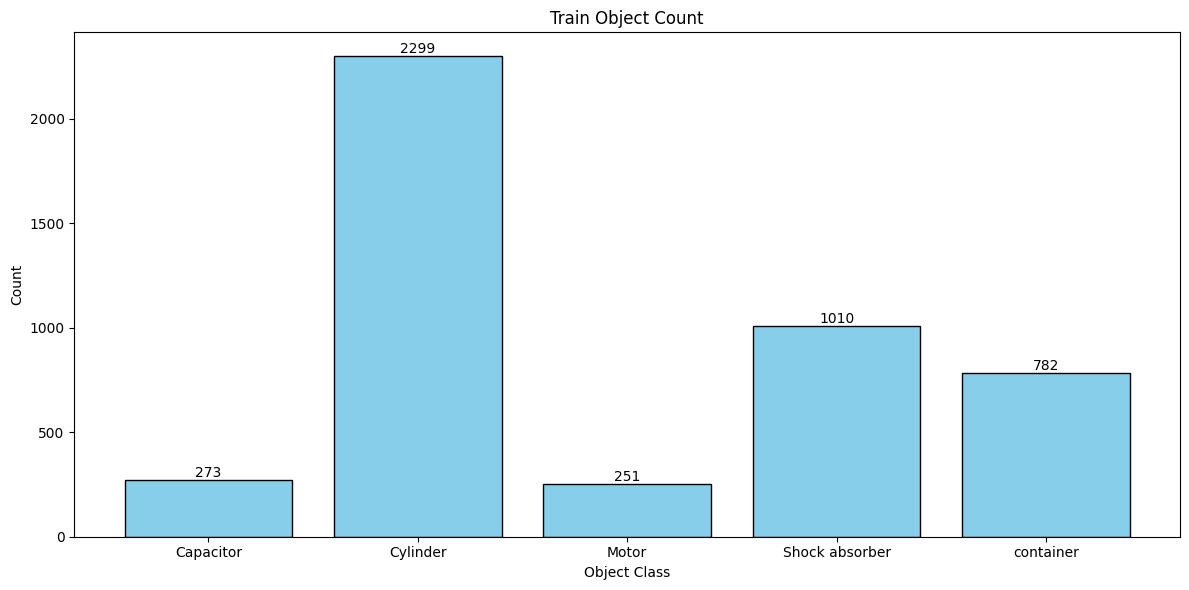

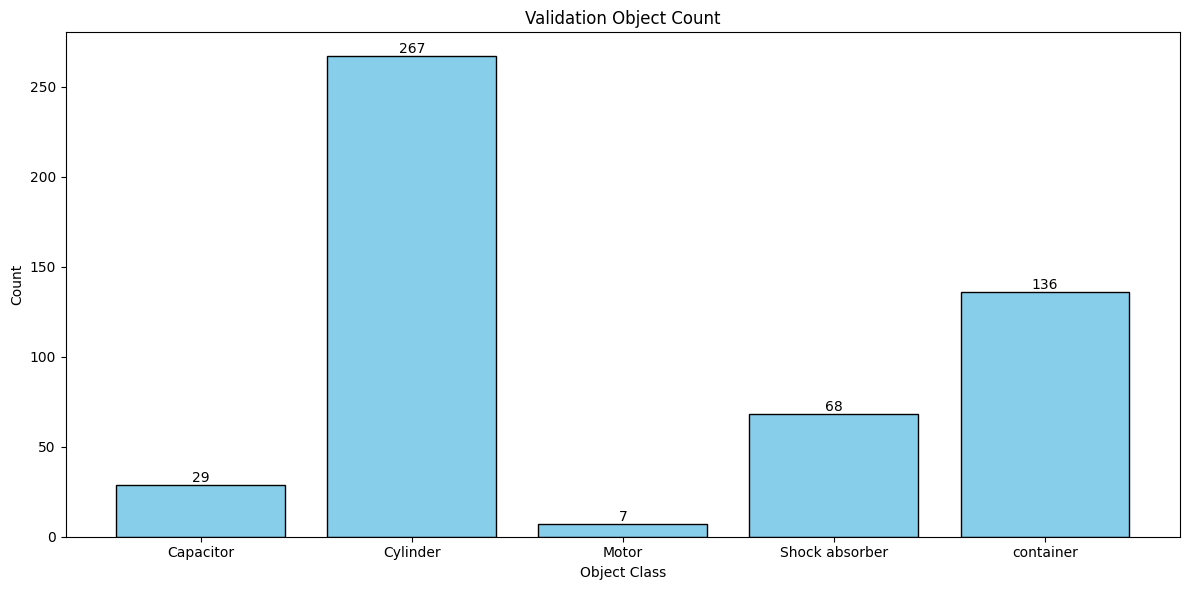

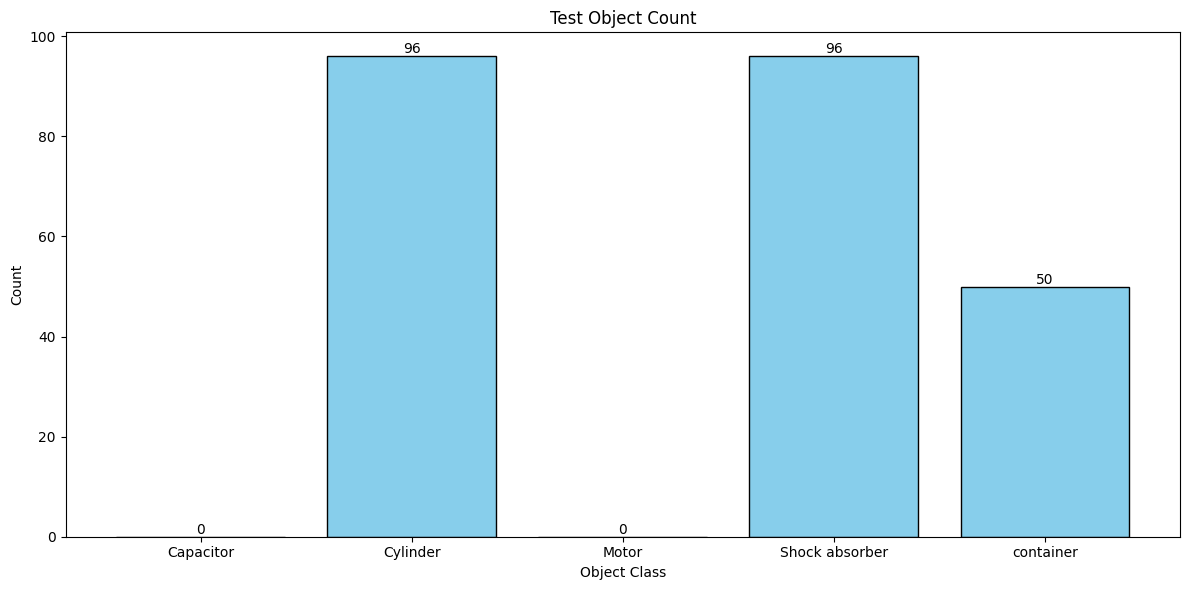

In [7]:
def plot_object_count(object_count, title):
    # Fill missing classes with count 0
    filled_counts = {cls: object_count.get(cls, 0) for cls in classes}
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(filled_counts.keys(), filled_counts.values(), color='skyblue', edgecolor='black')
    plt.title(title)
    
    # Add counts above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
                 ha='center', va='bottom', fontsize=10)

    plt.xlabel("Object Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
plot_object_count(train_object_count, "Train Object Count")
plot_object_count(val_object_count, "Validation Object Count")
plot_object_count(test_object_count, "Test Object Count")

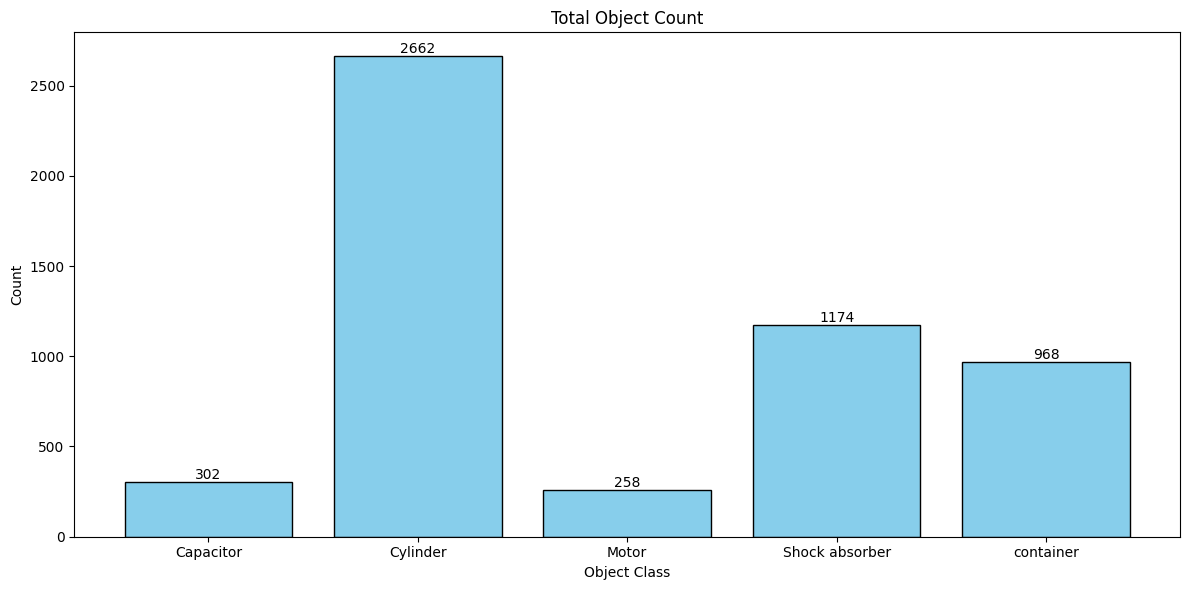

In [8]:
total_object_count = {label: train_object_count.get(label, 0) + val_object_count.get(label, 0) + test_object_count.get(label, 0) for label in classes}
plot_object_count(total_object_count, "Total Object Count")

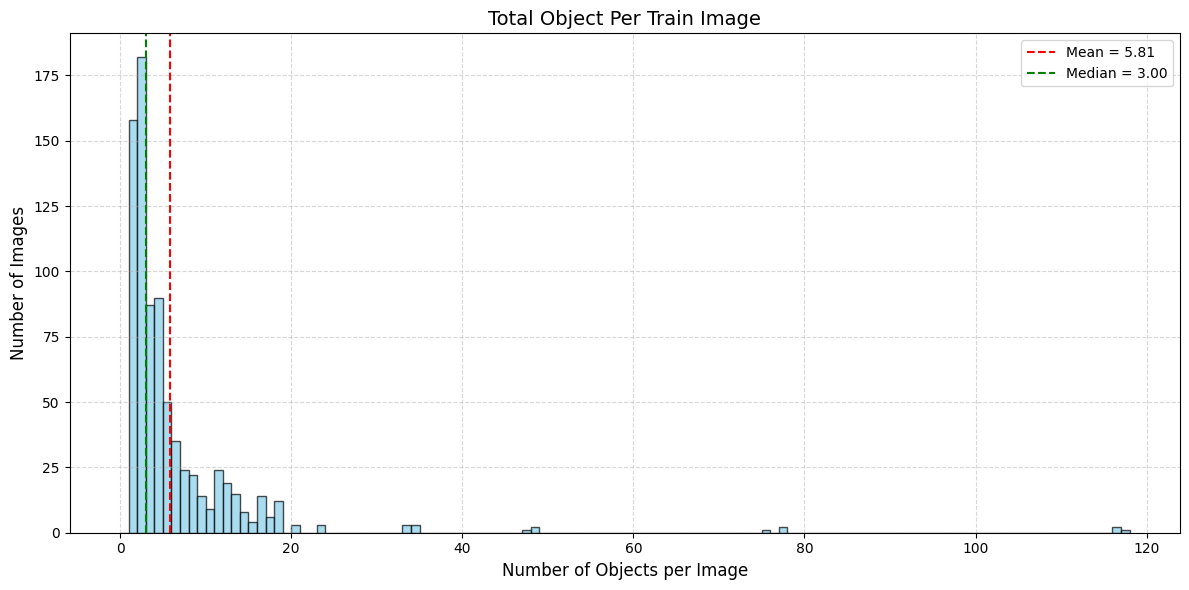

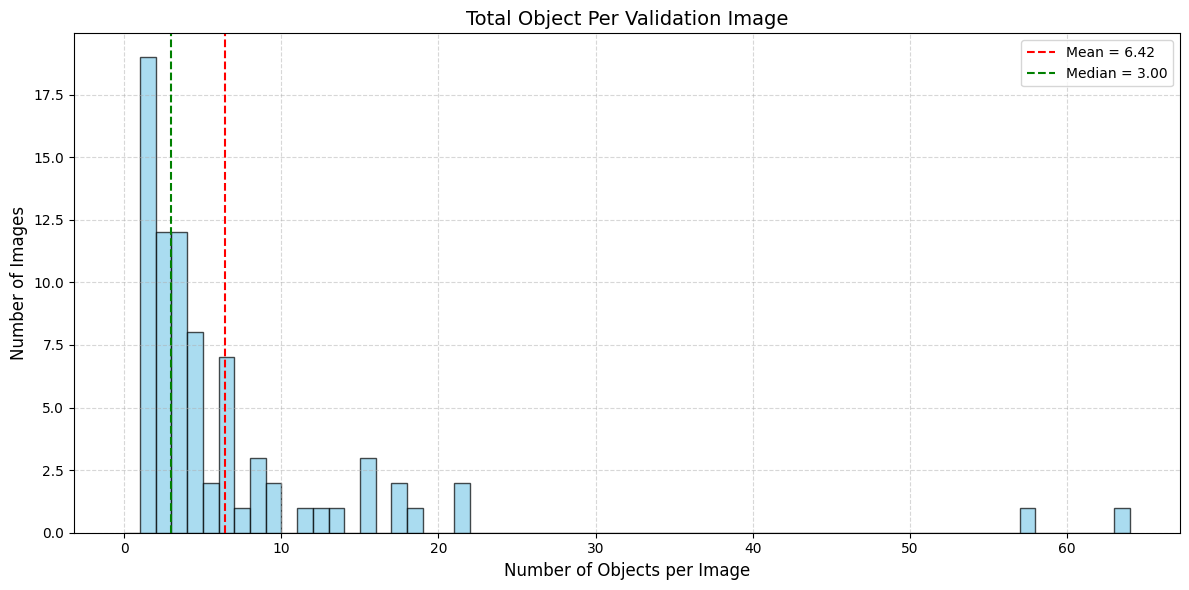

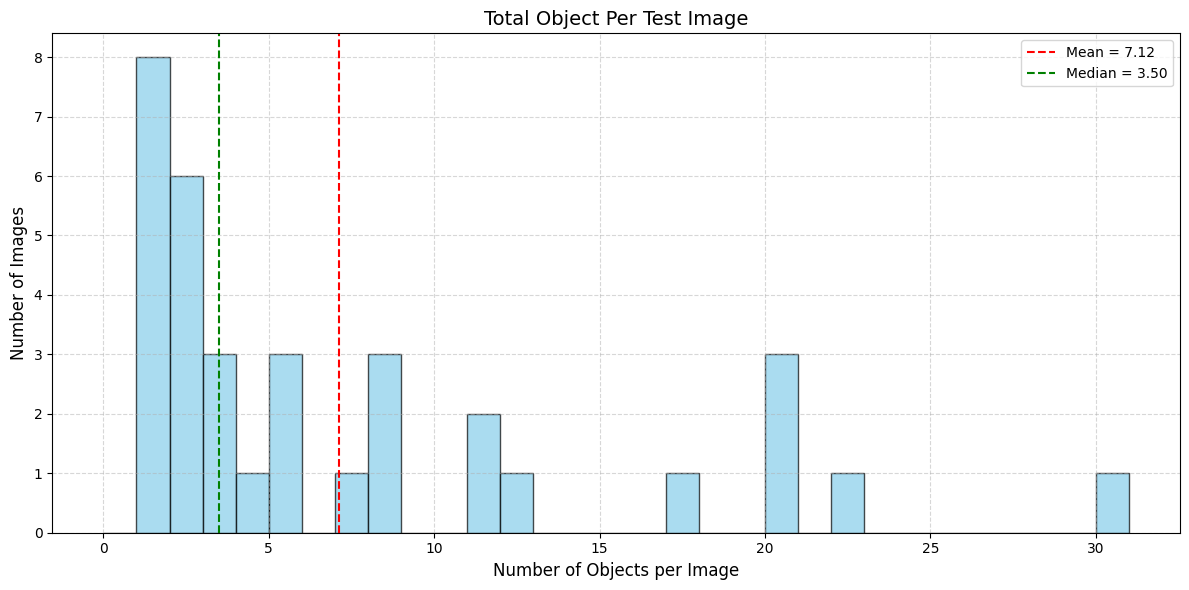

In [12]:
def plot_total_object_per_image(total_object_per_image, title):
    plt.figure(figsize=(12, 6))
    
    # Histogram
    counts, bins, patches = plt.hist(total_object_per_image, bins=range(0, max(total_object_per_image)+2), 
                                     color='skyblue', edgecolor='black', alpha=0.7)

    # Stats
    mean_val = np.mean(total_object_per_image)
    median_val = np.median(total_object_per_image)

    # Plot mean & median lines
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean = {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='--', linewidth=1.5, label=f'Median = {median_val:.2f}')

    # Labels and title
    plt.title(title, fontsize=14)
    plt.xlabel("Number of Objects per Image", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
plot_total_object_per_image(total_object_per_train_count, "Total Object Per Train Image")
plot_total_object_per_image(total_object_per_val_count, "Total Object Per Validation Image")
plot_total_object_per_image(total_object_per_test_count, "Total Object Per Test Image")

Processing images: 100%|██████████| 34/34 [00:00<00:00, 15357.13it/s]


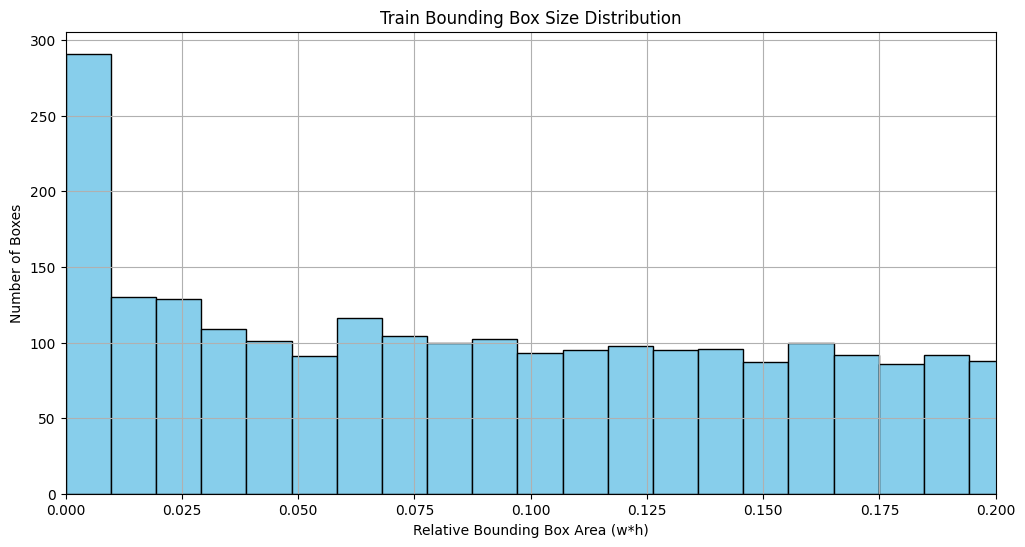

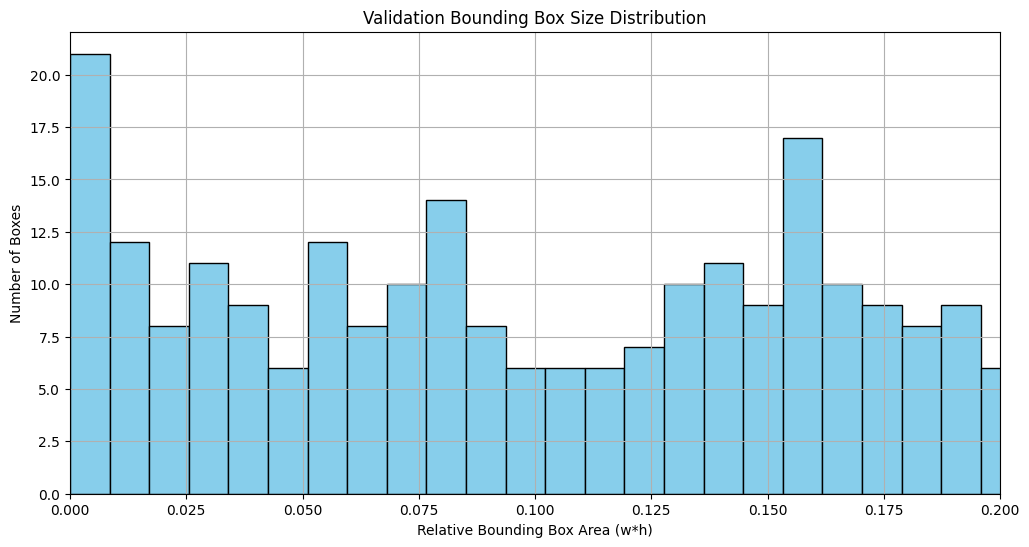

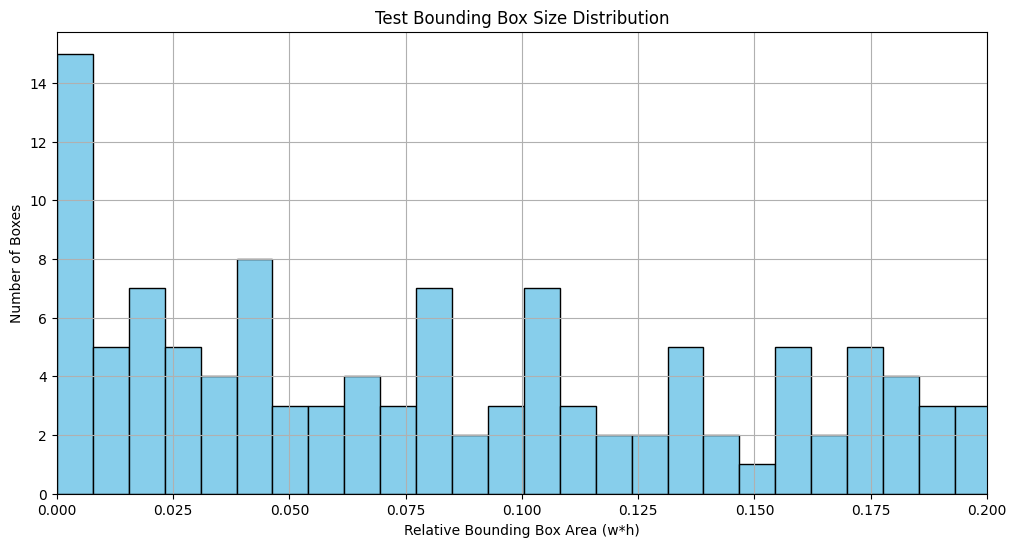

In [20]:
def calculate_bbox_areas(image_dir, label_dir):
    """
    Reads label files and calculates the area of each bounding box.
    
    Args:
        image_dir (str): Directory where images are stored.
        label_dir (str): Directory where YOLO-format label files are stored.
    
    Returns:
        List of bounding box areas (relative values between 0 and 1).
    """
    bbox_areas = []
    image_files = sorted(os.listdir(image_dir))
    
    for image_file in tqdm.tqdm(image_files, desc=f"Processing {os.path.basename(image_dir)}"):
        label_path = os.path.join(label_dir, image_file.rsplit(".", 1)[0] + ".txt")
        
        if not os.path.exists(label_path):
            continue  # Skip if label file doesn't exist
        
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue  # Skip if the line is malformed
                width = float(parts[3])
                height = float(parts[4])
                area = width * height
                bbox_areas.append(area)
    
    return bbox_areas

def plot_bbox_area_distribution(areas, title):
    """
    Plots a histogram of bounding box areas.

    Args:
        areas (list): List of bounding box areas.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.hist(areas, bins=100, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Relative Bounding Box Area (w*h)")
    plt.ylabel("Number of Boxes")
    plt.xlim(0, 0.2)  # Focus on smaller boxes
    plt.grid(True)
    plt.show()

# Load bounding box areas for each dataset split
train_bbox_areas = calculate_bbox_areas(TRAIN_IMAGES, TRAIN_LABELS)
val_bbox_areas = calculate_bbox_areas(VAL_IMAGES, VAL_LABELS)
test_bbox_areas = calculate_bbox_areas(TEST_IMAGES, TEST_LABELS)

# Plot the distributions
plot_bbox_area_distribution(train_bbox_areas, "Train Bounding Box Size Distribution")
plot_bbox_area_distribution(val_bbox_areas, "Validation Bounding Box Size Distribution")
plot_bbox_area_distribution(test_bbox_areas, "Test Bounding Box Size Distribution")

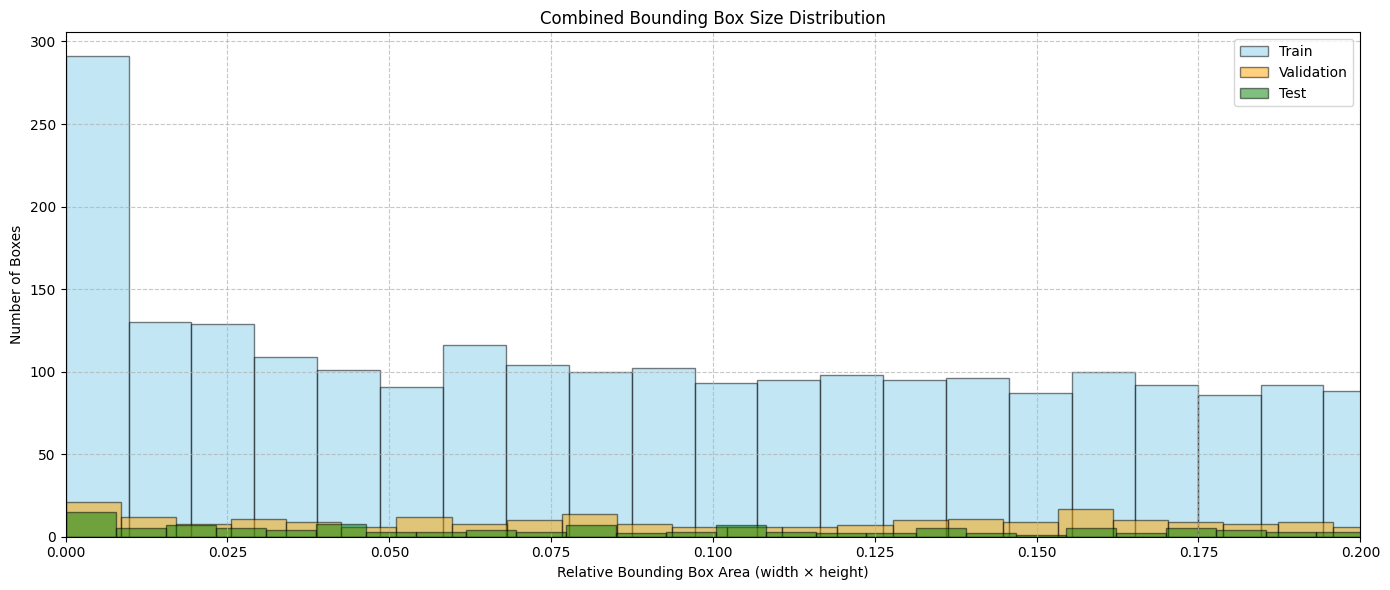

In [21]:
def plot_all_bbox_area_distributions(train_areas, val_areas, test_areas, title="Bounding Box Area Distribution (All Splits)", use_log_scale=False):
    """
    Plots a combined histogram of bounding box areas from train, val, and test datasets.

    Args:
        train_areas (list): List of bbox areas from the training set.
        val_areas (list): List of bbox areas from the validation set.
        test_areas (list): List of bbox areas from the test set.
        title (str): Title of the plot.
        use_log_scale (bool): Whether to use log scale on y-axis.
    """
    plt.figure(figsize=(14, 6))
    bins = 100  # Finer bins for smoother distribution view

    # Plot histograms with transparency (alpha) for overlap visibility
    plt.hist(train_areas, bins=bins, alpha=0.5, label='Train', color='skyblue', edgecolor='black')
    plt.hist(val_areas, bins=bins, alpha=0.5, label='Validation', color='orange', edgecolor='black')
    plt.hist(test_areas, bins=bins, alpha=0.5, label='Test', color='green', edgecolor='black')
    
    plt.title(title)
    plt.xlabel("Relative Bounding Box Area (width × height)")
    plt.ylabel("Number of Boxes")
    plt.xlim(0, 0.2)  # Focus on smaller boxes (typically more common)
    if use_log_scale:
        plt.yscale("log")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
plot_all_bbox_area_distributions(train_bbox_areas, val_bbox_areas, test_bbox_areas, title="Combined Bounding Box Size Distribution")

In [34]:
TEST_LABELS.split("/")[-2]

'test'

In [38]:
for train_val_test in ('train', 'valid', 'test'): 

    object_data = []
    IMAGES = f"/home/shirshak/Thesis_Data/Steel_Scrap_detection/{train_val_test}/images"
    LABELS = f"/home/shirshak/Thesis_Data/Steel_Scrap_detection/{train_val_test}/labels"

    for label_file in sorted(os.listdir(LABELS)):
        image_file = label_file.replace(".txt", ".jpg")  # or .png
        image_path = os.path.join(IMAGES, image_file)
        label_path = os.path.join(LABELS, label_file)

        if not os.path.exists(image_path):
            continue

        image = cv2.imread(image_path)
        if image is None:
            continue
        img_h, img_w = image.shape[:2]

        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                w_norm = float(parts[3])  # normalized width
                h_norm = float(parts[4])  # normalized height

                object_data.append({
                    "class_id": class_id,
                    "class_name": Idx2Label[class_id],
                    "length": w_norm * img_w,    # width in pixels
                    "breadth": h_norm * img_h    # height in pixels
                })
    if train_val_test == 'train':
        train_df = pd.DataFrame(object_data)

    if train_val_test == 'valid':
        val_df = pd.DataFrame(object_data)
        
    if train_val_test == 'test':
        test_df = pd.DataFrame(object_data)

In [40]:
train_df

,class_id,class_name,length,breadth
0,1,Cylinder,198.125000,172.413793
1,1,Cylinder,258.125000,425.412294
2,1,Cylinder,531.250000,334.520239
3,1,Cylinder,532.500000,570.652173
4,1,Cylinder,462.058916,509.971429
...,...,...,...,...
4610,0,Capacitor,306.875000,3.121019
4611,0,Capacitor,161.874537,216.653122
4612,0,Capacitor,532.092033,473.840093
4613,0,Capacitor,449.717472,633.640946


In [41]:
val_df

,class_id,class_name,length,breadth
0,3,Shock absorber,516.844569,571.875000
1,3,Shock absorber,369.367978,411.250000
2,3,Shock absorber,442.429775,421.250000
3,1,Cylinder,286.835206,551.875000
4,1,Cylinder,170.625000,267.893258
...,...,...,...,...
502,4,container,548.124999,426.250000
503,4,container,562.500000,344.609376
504,4,container,360.000000,178.681931
505,4,container,265.000000,251.392327


In [42]:
test_df

,class_id,class_name,length,breadth
0,1,Cylinder,388.309925,556.250000
1,1,Cylinder,185.824468,408.750000
2,1,Cylinder,539.840426,405.625000
3,1,Cylinder,265.851064,516.875000
4,1,Cylinder,492.367021,563.750000
...,...,...,...,...
237,1,Cylinder,378.750001,589.687500
238,4,container,165.625000,337.653479
239,4,container,581.250000,469.901092
240,4,container,204.375000,495.225102


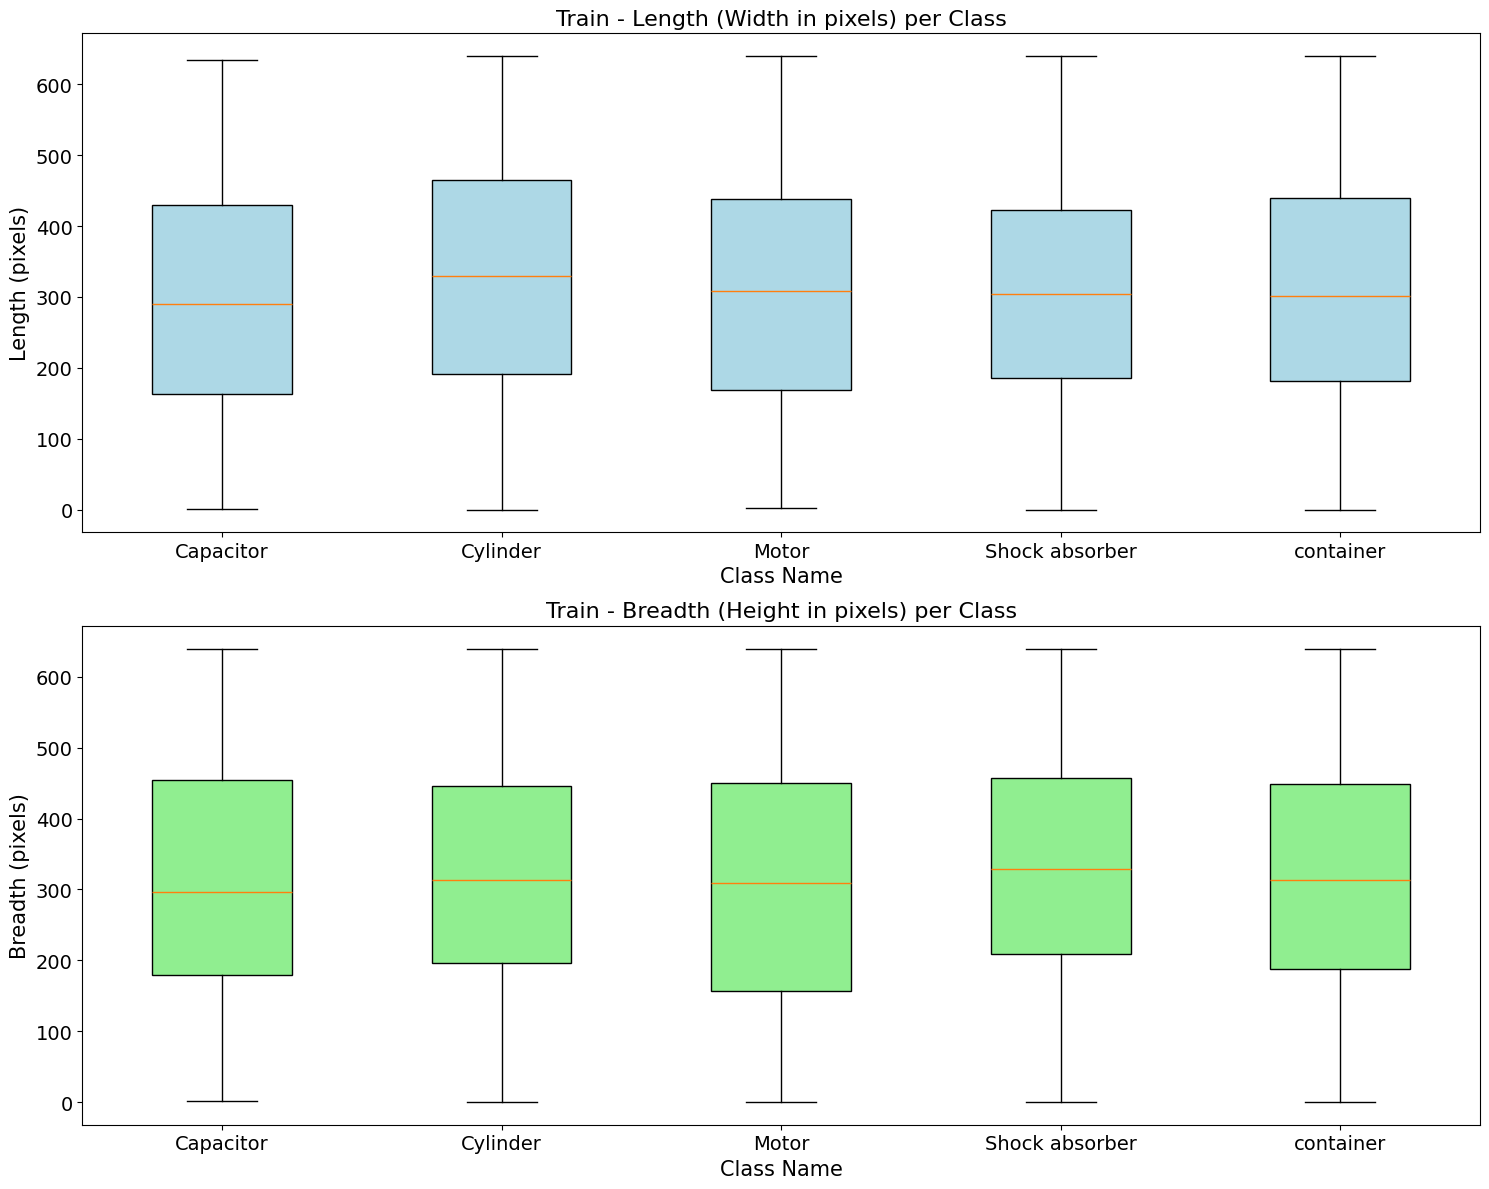

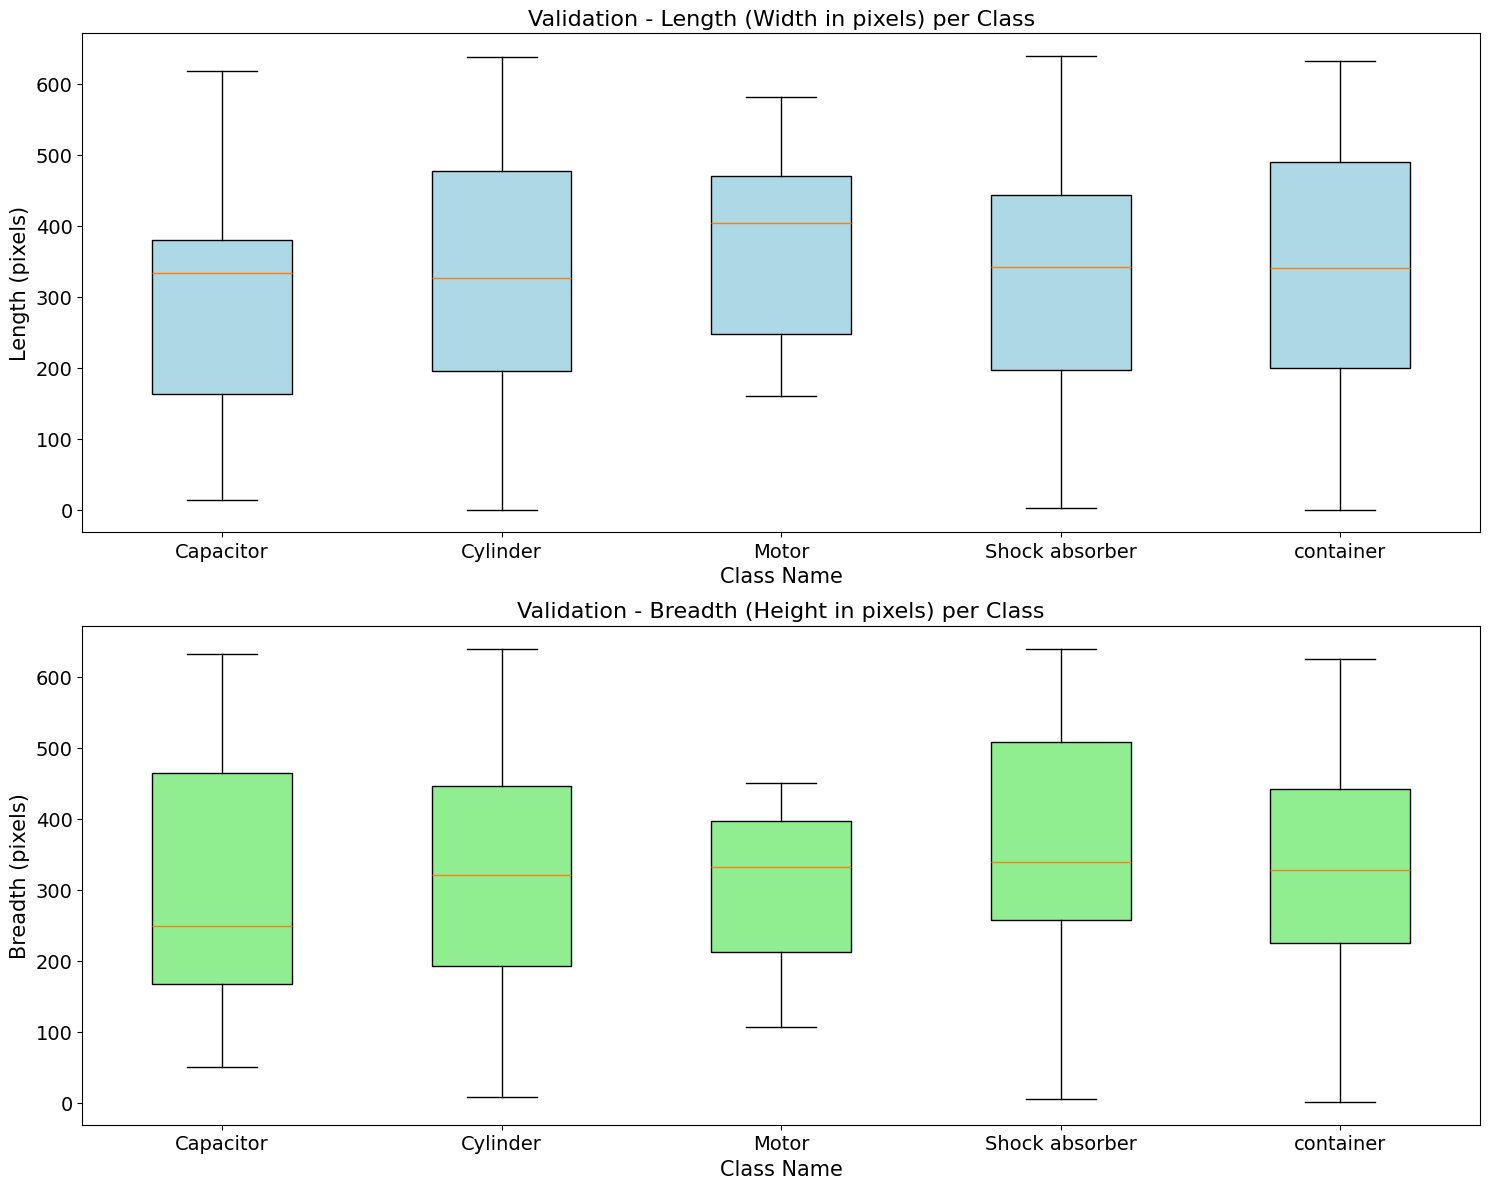

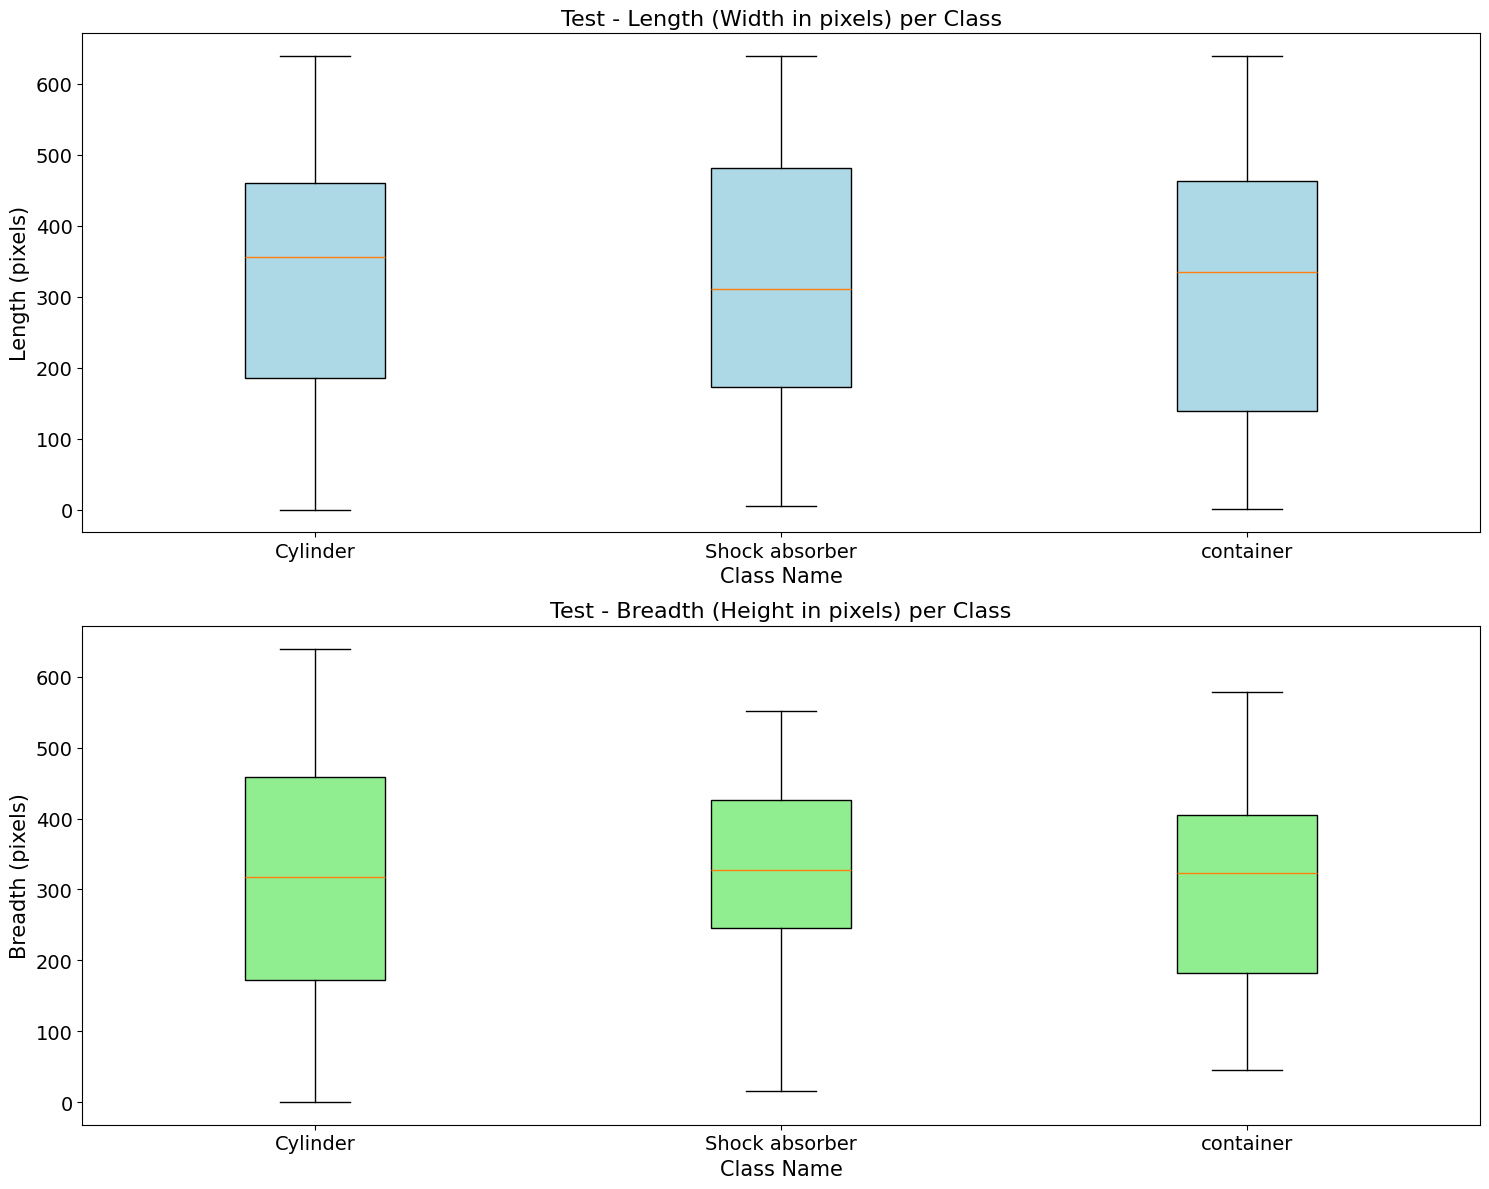

In [54]:
for df_name, df in zip(["Train", "Validation", "Test"], [train_df, val_df, test_df]):
    
    class_names = sorted(df['class_name'].unique())
    length_data = [df[df['class_name'] == cls]['length'].values for cls in class_names]
    breadth_data = [df[df['class_name'] == cls]['breadth'].values for cls in class_names]
    
    fig, ax = plt.subplots(nrows=2, figsize=(15, 12))
    
    # Length boxplot
    ax[0].boxplot(length_data, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    ax[0].set_title(f"{df_name} - Length (Width in pixels) per Class", fontsize=16)
    ax[0].set_xlabel("Class Name", fontsize=15)
    ax[0].set_ylabel("Length (pixels)", fontsize=15)
    ax[0].set_xticks(range(1, len(class_names) + 1))
    ax[0].set_xticklabels(class_names, fontsize=14)
    ax[0].tick_params(axis='y', labelsize=14)
    
    # Breadth boxplot
    ax[1].boxplot(breadth_data, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
    ax[1].set_title(f"{df_name} - Breadth (Height in pixels) per Class", fontsize=16)
    ax[1].set_xlabel("Class Name", fontsize=15)
    ax[1].set_ylabel("Breadth (pixels)", fontsize=15)
    ax[1].set_xticks(range(1, len(class_names) + 1))
    ax[1].set_xticklabels(class_names, fontsize=14)
    ax[1].tick_params(axis='y', labelsize=14)
    
    plt.tight_layout()
    plt.show()